In [14]:
#k最近傍法（2018年12月〜2019年6月中旬までの糖度を予測）

In [15]:
%matplotlib inline
import sys
sys.path.append('/home/yoshida/.pyenv/versions/3.6.6/lib/python3.6/site-packages')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [16]:
# データの読み込み
data = pd.read_csv("../src/Aiko_normalization_ver3_aaa.csv")
df = pd.DataFrame(data)

In [17]:
df.drop(['No','width','height','seed_date','house','url', 'COL_21'], axis=1, inplace=True) #対象の列を削除

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 14 columns):
current_date      2176 non-null object
sweet             2176 non-null float64
sweet_category    2176 non-null int64
size              2176 non-null float64
AveCO2_7          2176 non-null float64
AveSatu_7         2176 non-null float64
AveHum_7          2176 non-null float64
AveTemp_7         2176 non-null float64
AveMaxTemp_7      2176 non-null float64
AveMinTemp_7      2176 non-null float64
AveDiffTemp_7     2176 non-null float64
SumMaxTemp_7      2176 non-null float64
SumMinTemp_7      2176 non-null float64
SumDiffTemp_7     2176 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 238.1+ KB


In [19]:
# AveDiffTemp_7、AveSatu_7、monthを対象としたい時
#df.drop(['AveCO2_7', 'AveSatu_7', 'AveTemp_7', 'AveHum_7', 'AveMinTemp_7', 'AveDiffTemp_7', 'SumMaxTemp_7','SumMinTemp_7','SumDiffTemp_7'], axis=1, inplace=True)

In [20]:
df.head()

,current_date,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
0,11月28日,4.3,2,7.54,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
1,11月28日,4.5,2,6.48,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
2,11月28日,4.0,1,8.68,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
3,11月28日,3.5,1,10.50,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9
4,11月28日,4.3,2,7.00,614.28,6.17,66.84,21.14,26.24,18.83,7.41,183.7,131.8,51.9


In [21]:
# 'AveCO2_7', 'AveSatu_7', 'AveHum_7', 'AveTemp_7', 'AveMaxTemp_7', 'AveMinTemp_7','AveDiffTemp_7','SumMaxTemp_7','SumMinTemp_7','SumDiffTemp_7'

In [9]:
df['month'] = df['current_date'].str[:2] # "11月28日"とか"4月3日"の月日の先頭2文字だけ抽出
df['month'] = df['month'].str.strip('月') # このままだと"4月"のように"月"が入っているので、"月"を削除する
# 参考：https://deepage.net/features/pandas-str-extract.html
# 参考：https://deepage.net/features/pandas-str-replace.html
df['month'].isnull().sum() # 欠損値がないかを確認

df.drop(['current_date'], axis=1, inplace=True) # current_dateはもう使わない
print(df.shape)

(2176, 14)


In [10]:
# 四半期を求める(4~6月:1st、7~9月:2nd、10~12月:3rd、1~3月:4th)(＊＊＊＊使うか使わないか＊＊＊＊)
df['quarter'] = df['month'].replace({'4': '1st', '5': '1st', '6': '1st', 
                                     '7': '2nd', '8': '2nd', '9': '2nd', 
                                     '10': '3rd', '11': '3rd', '12': '3rd', 
                                     '1': '4th', '2': '4th', '3': '4th'
                                    })

In [11]:
# ダミー変数の作成
df = pd.get_dummies(df, columns=['quarter'], drop_first=True)

In [12]:
df.drop(['month'], axis=1, inplace=True)

In [22]:
df.describe()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
count,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000
mean,4.689890,2.776654,6.568267,534.566678,7.531237,62.433931,21.766846,27.484560,17.887496,9.595469,192.386765,125.213529,67.173456
std,0.530061,0.977789,1.830271,100.540048,1.402898,3.964303,1.362018,2.714338,1.485614,3.226052,19.002837,10.400903,22.577841
min,3.000000,1.000000,2.560000,400.770000,5.800000,55.550000,20.250000,22.700000,11.560000,4.590000,158.900000,80.930000,32.100000
25%,4.300000,2.000000,5.250000,443.180000,6.400000,59.690000,20.760000,25.890000,17.770000,7.740000,181.200000,124.400000,54.200000
50%,4.700000,3.000000,6.440000,504.820000,7.370000,61.330000,21.390000,26.240000,18.210000,8.160000,183.700000,127.500000,57.100000
75%,5.100000,4.000000,7.800000,622.340000,8.075000,66.270000,22.410000,29.060000,18.670000,12.250000,203.400000,130.700000,85.750000
max,6.000000,4.000000,14.000000,760.640000,11.900000,70.810000,25.930000,34.540000,19.630000,17.500000,241.800000,137.400000,122.480000


In [23]:
df.corr()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7
sweet,1.000000,0.948026,-0.845930,0.149696,-0.102477,-0.086414,-0.231788,-0.256549,0.087282,-0.256248,-0.256605,0.087076,-0.256092
sweet_category,0.948026,1.000000,-0.845716,0.147071,-0.095435,-0.092968,-0.227828,-0.250357,0.088490,-0.251585,-0.250397,0.088279,-0.251422
size,-0.845930,-0.845716,1.000000,-0.316388,0.270745,-0.005937,0.417896,0.411442,-0.165116,0.422383,0.411474,-0.164920,0.422303
AveCO2_7,0.149696,0.147071,-0.316388,1.000000,-0.655139,0.406979,-0.700366,-0.647394,0.195133,-0.634566,-0.647212,0.195217,-0.634670
AveSatu_7,-0.102477,-0.095435,0.270745,-0.655139,1.000000,-0.795076,0.876089,0.728993,0.004405,0.611319,0.728858,0.004476,0.611402
AveHum_7,-0.086414,-0.092968,-0.005937,0.406979,-0.795076,1.000000,-0.438052,-0.204585,-0.020980,-0.162219,-0.204393,-0.021014,-0.162364
AveTemp_7,-0.231788,-0.227828,0.417896,-0.700366,0.876089,-0.438052,1.000000,0.875936,-0.003704,0.738866,0.875861,-0.003649,0.738867
AveMaxTemp_7,-0.256549,-0.250357,0.411442,-0.647394,0.728993,-0.204585,0.875936,1.000000,-0.102683,0.888889,1.000000,-0.102540,0.888901
AveMinTemp_7,0.087282,0.088490,-0.165116,0.195133,0.004405,-0.020980,-0.003704,-0.102683,1.000000,-0.546973,-0.102467,0.999998,-0.546952
AveDiffTemp_7,-0.256248,-0.251585,0.422383,-0.634566,0.611319,-0.162219,0.738866,0.888889,-0.546973,1.000000,0.888790,-0.546853,1.000000


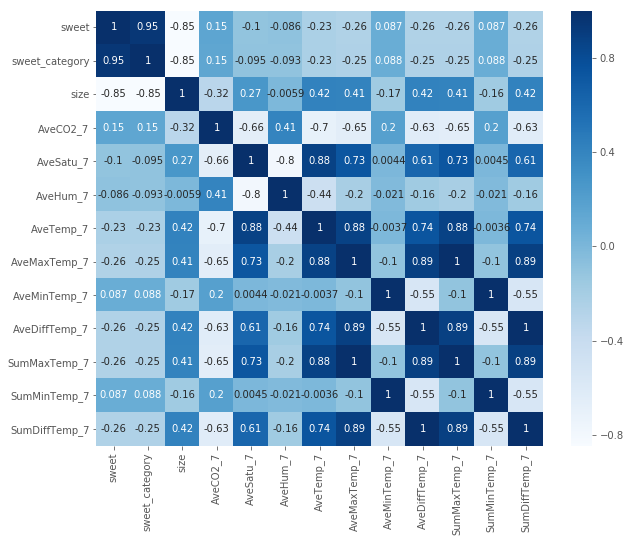

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='Blues')

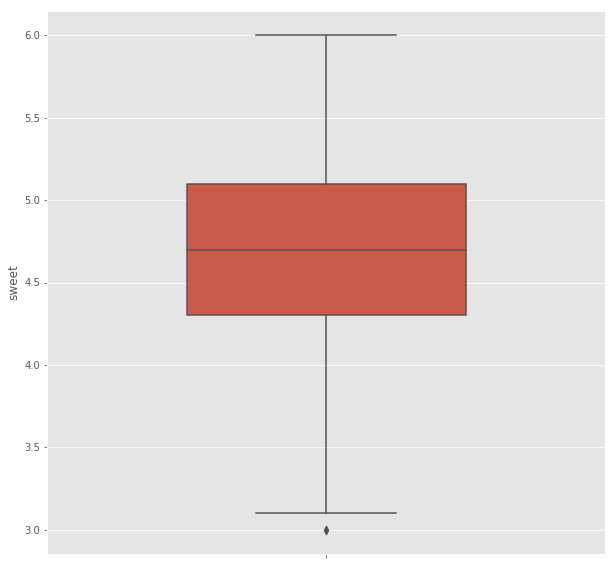

In [25]:
plt.figure(figsize=(10, 10))
sns.boxplot(df['sweet'], orient='v', width=0.5)

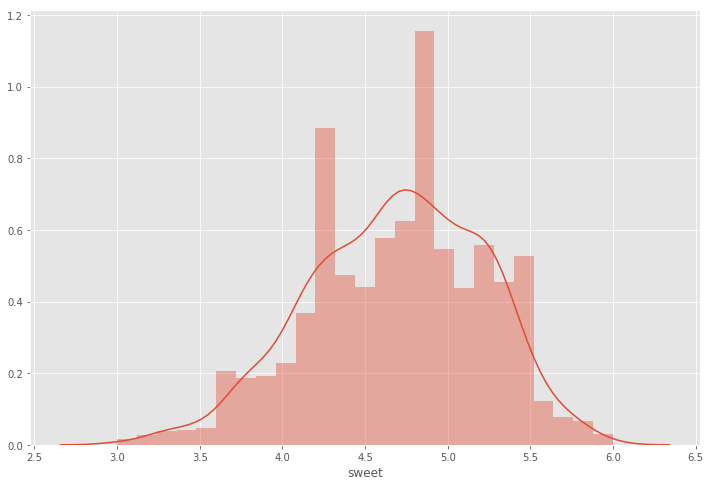

In [26]:
plt.figure(figsize=(12, 8))
sns.distplot(df['sweet'])

In [27]:
print(df.columns)

Index(['current_date', 'sweet', 'sweet_category', 'size', 'AveCO2_7',
       'AveSatu_7', 'AveHum_7', 'AveTemp_7', 'AveMaxTemp_7', 'AveMinTemp_7',
       'AveDiffTemp_7', 'SumMaxTemp_7', 'SumMinTemp_7', 'SumDiffTemp_7'],
      dtype='object')


In [28]:
df.shape

(2176, 14)

In [29]:
# sweet_categoryが1のものについて
df_1 = df[(df['sweet_category'] == 1)]

In [30]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257 entries, 2 to 2164
Data columns (total 14 columns):
current_date      257 non-null object
sweet             257 non-null float64
sweet_category    257 non-null int64
size              257 non-null float64
AveCO2_7          257 non-null float64
AveSatu_7         257 non-null float64
AveHum_7          257 non-null float64
AveTemp_7         257 non-null float64
AveMaxTemp_7      257 non-null float64
AveMinTemp_7      257 non-null float64
AveDiffTemp_7     257 non-null float64
SumMaxTemp_7      257 non-null float64
SumMinTemp_7      257 non-null float64
SumDiffTemp_7     257 non-null float64
dtypes: float64(12), int64(1), object(1)
memory usage: 30.1+ KB


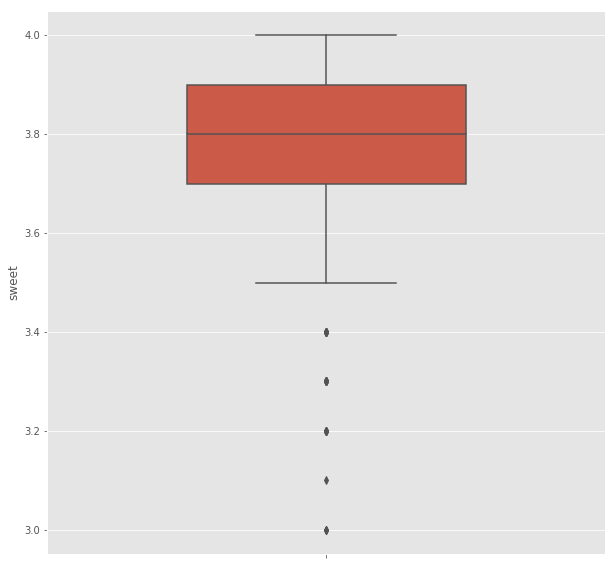

In [31]:
plt.figure(figsize=(10, 10))
sns.boxplot(df_1['sweet'], orient='v', width=0.5)

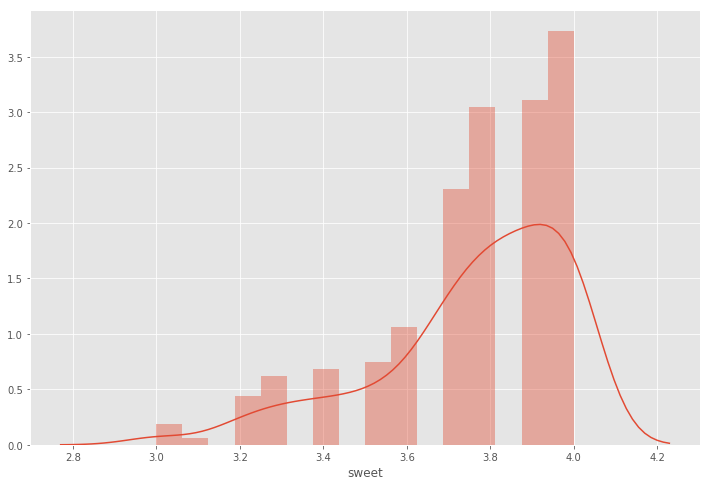

In [32]:
plt.figure(figsize=(12, 8))
sns.distplot(df_1['sweet'])

In [33]:
def outlier_iqr(df, columns=None):
    if columns == None:
        columns = df.columns
    for col in columns:
        q1 = df[col].describe()['25%']
        q3 = df[col].describe()['75%']
        # 四分位範囲
        iqr = q3 - q1
        outlier_min = q1 - iqr * 1.5
        outlier_max = q3 + iqr * 1.5
        # 範囲から外れている値を除く
        df = df[(df[col] >= outlier_min) & (df[col] <= outlier_max)]
    return df

In [34]:
print("before", df_1.shape)
df_1 = outlier_iqr(df_1, ['sweet'])
print("after", df_1.shape)

before (257, 14)
after (225, 14)


In [35]:
def outlier_std(df, thresh=3, columns=None):
    if columns == None:
        columns = df.columns
    print(thresh)
    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        # 平均値から標準偏差の何倍離れているかを計算
        border = (np.abs(df[col] - mean)) / std # absは絶対値
        # 標準偏差の3倍以上離れているデータを除外
        df = df[(border < 3)]
    return df

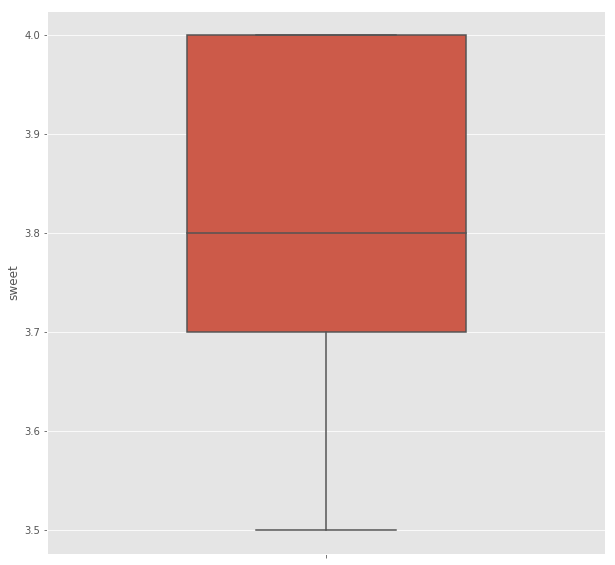

In [36]:
plt.figure(figsize=(10, 10))
sns.boxplot(df_1['sweet'], orient='v', width=0.5)

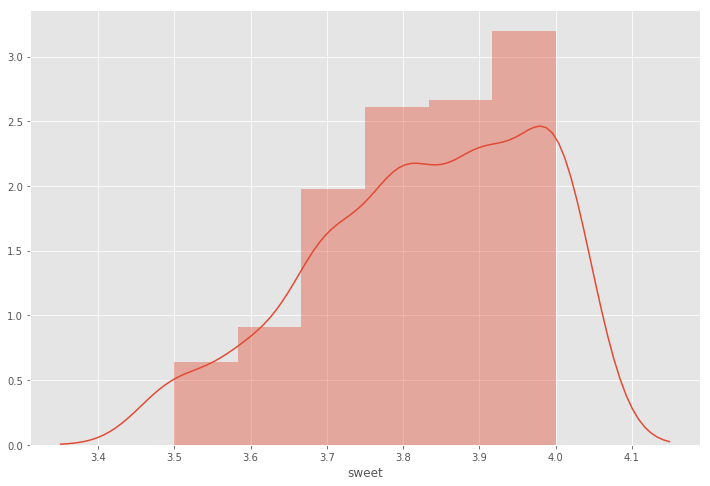

In [37]:
plt.figure(figsize=(12, 8))
sns.distplot(df_1['sweet'])

In [38]:
# sweet_categoryが2のものについて
df_2 = df[(df['sweet_category'] == 2)]

In [39]:
df_2.shape

(566, 14)

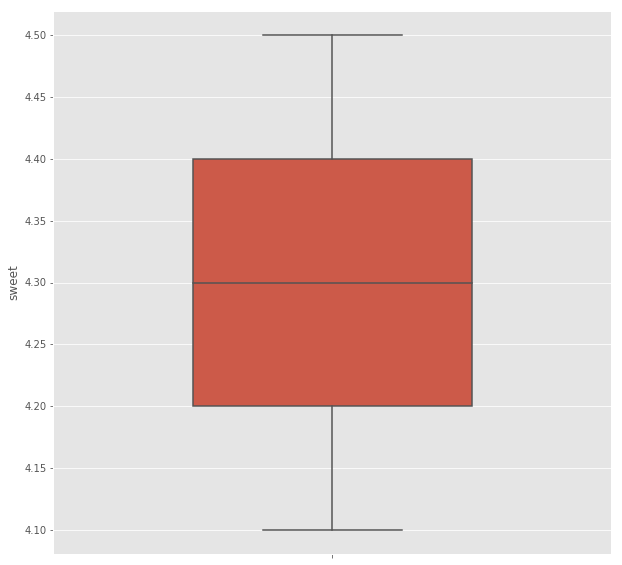

In [40]:
plt.figure(figsize=(10, 10))
sns.boxplot(df_2['sweet'], orient='v', width=0.5)

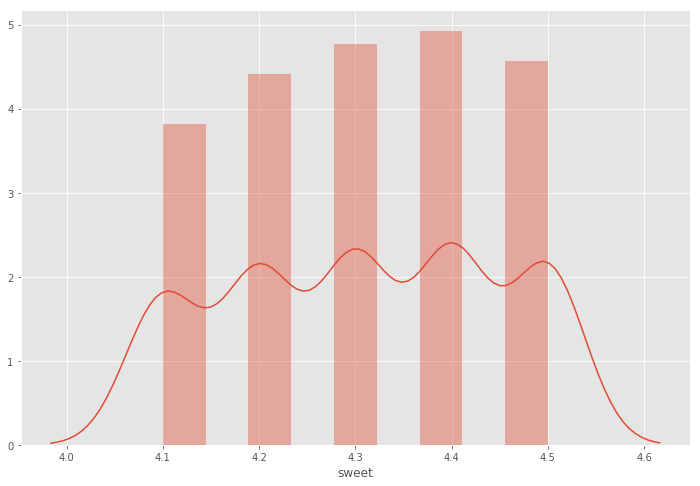

In [31]:
plt.figure(figsize=(12, 8))
sns.distplot(df_2['sweet'])

In [32]:
print("before", df_2.shape)
df_2 = outlier_iqr(df_2, ['sweet'])
print("after", df_2.shape)

before (566, 15)
after (566, 15)


In [33]:
# sweet_categoryが3のものについて
df_3 = df[(df['sweet_category'] == 3)]

In [34]:
df_3.shape

(759, 15)

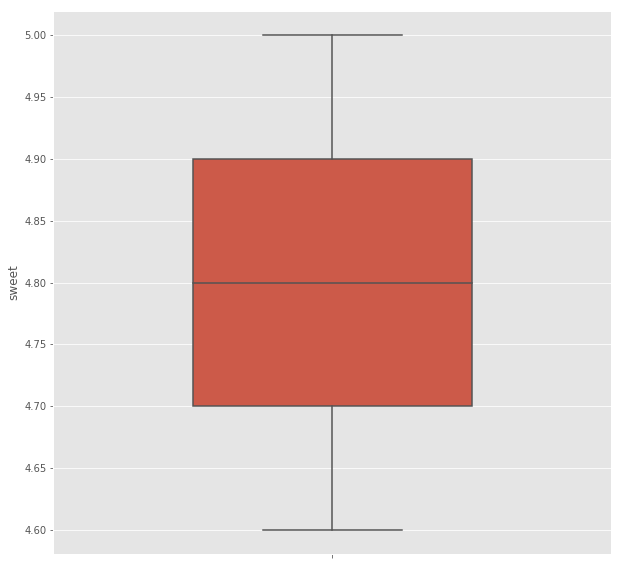

In [35]:
plt.figure(figsize=(10, 10))
sns.boxplot(df_3['sweet'], orient='v', width=0.5)

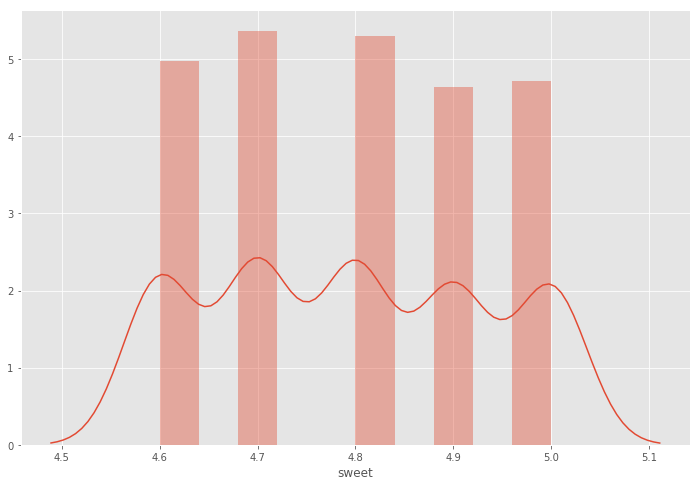

In [36]:
plt.figure(figsize=(12, 8))
sns.distplot(df_3['sweet'])

In [37]:
print("before", df_3.shape)
df_3 = outlier_iqr(df_3, ['sweet'])
print("after", df_3.shape)

before (759, 15)
after (759, 15)


In [38]:
# sweet_categoryが4のものについて
df_4 = df[(df['sweet_category'] == 4)]

In [39]:
df_4.shape

(594, 15)

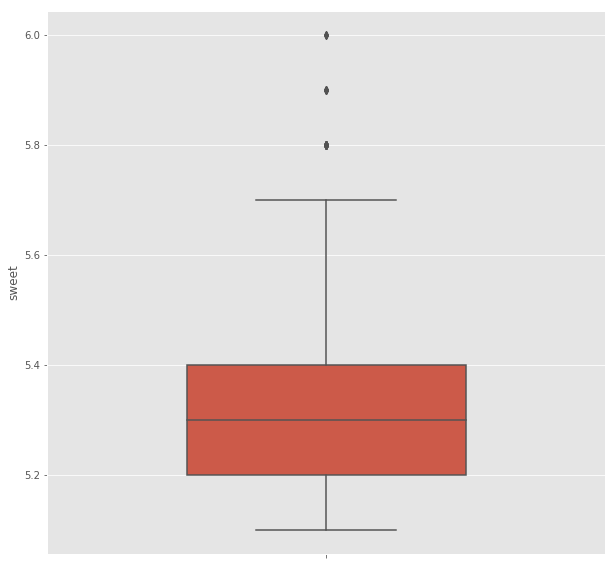

In [40]:
plt.figure(figsize=(10, 10))
sns.boxplot(df_4['sweet'], orient='v', width=0.5)

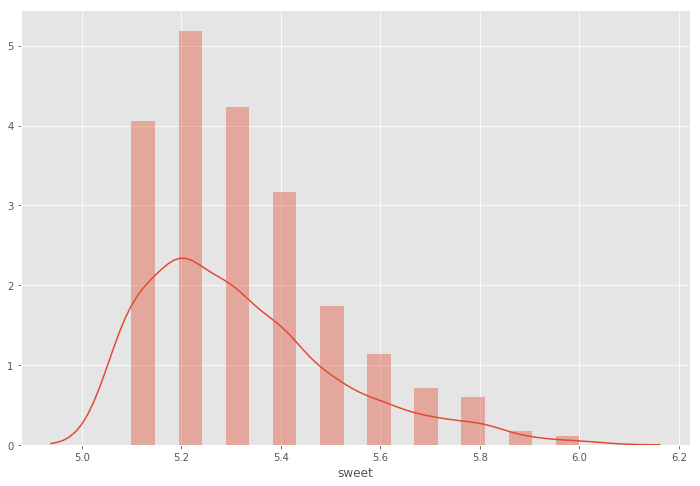

In [42]:
plt.figure(figsize=(12, 8))
sns.distplot(df_4['sweet'])

In [43]:
print("before", df_4.shape)
df_4 = outlier_iqr(df_4, ['sweet'])
print("after", df_4.shape)

before (594, 15)
after (569, 15)


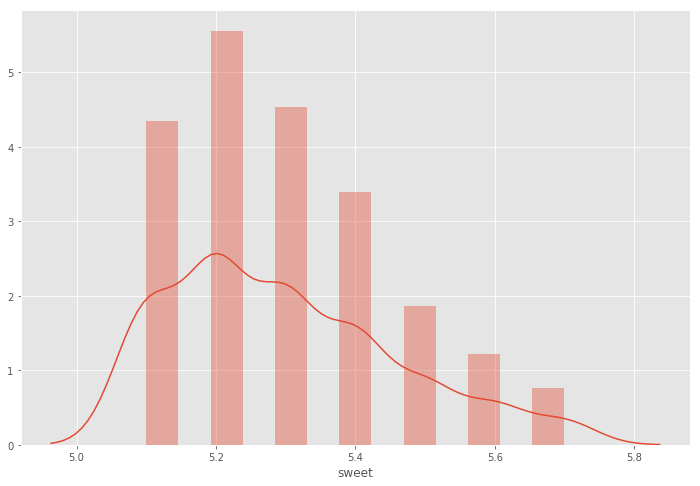

In [44]:
plt.figure(figsize=(12, 8))
sns.distplot(df_4['sweet'])

In [48]:
# 4つのデータフレームを結合
df_new = pd.concat([df_1, df_2, df_3, df_4])
# ランダムに並び替える＆indexを再振り
df_new = df_new.sample(frac=1).reset_index(drop=True)

In [49]:
df_new.head()

,sweet,sweet_category,size,AveCO2_7,AveSatu_7,AveHum_7,AveTemp_7,AveMaxTemp_7,AveMinTemp_7,AveDiffTemp_7,SumMaxTemp_7,SumMinTemp_7,SumDiffTemp_7,quarter_3rd,quarter_4th
0,5.3,4,4.60,712.07,6.64,62.71,20.37,24.66,17.94,6.71,172.6,125.6,47.0,0,1
1,4.8,3,8.40,428.39,11.90,55.55,25.93,34.54,19.63,14.91,241.8,137.4,104.4,0,0
2,4.8,3,5.76,481.18,9.62,60.48,23.74,33.84,19.31,14.53,236.9,135.2,101.7,0,0
3,4.9,3,5.52,531.89,7.70,60.07,21.56,26.07,18.77,7.30,182.5,131.4,51.1,0,0
4,3.9,1,8.58,719.70,5.92,66.31,20.25,22.70,18.11,4.59,158.9,126.8,32.1,1,0


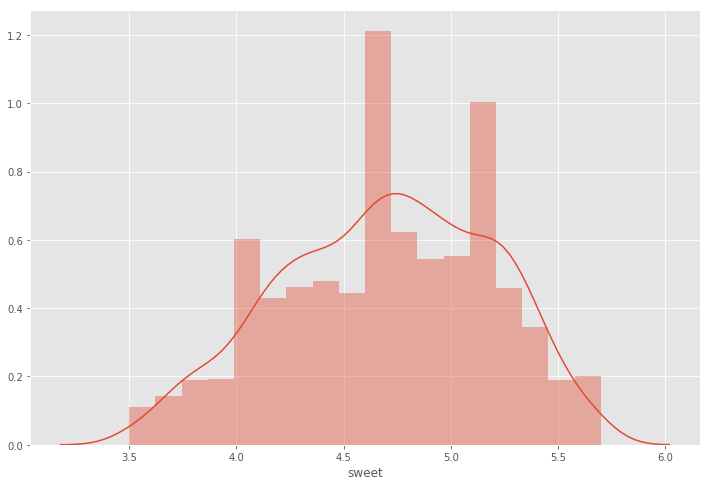

In [50]:
plt.figure(figsize=(12, 8))
sns.distplot(df_new['sweet'])

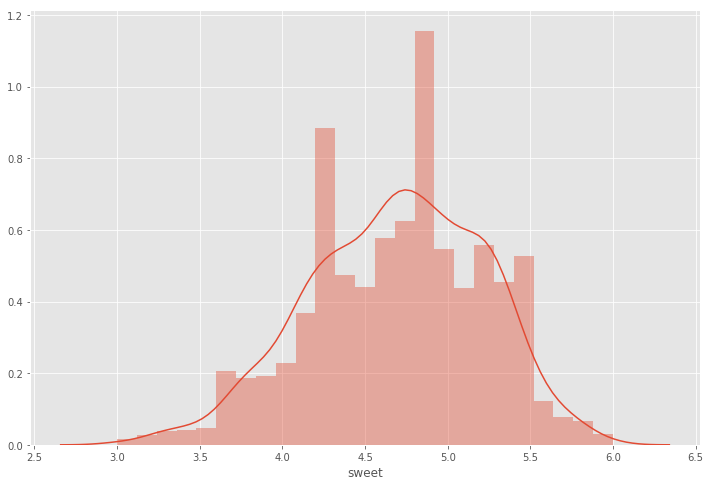

In [51]:
plt.figure(figsize=(12, 8))
sns.distplot(df['sweet'])

In [103]:
df['month'] = df['current_date'].str[:2] # "11月28日"とか"4月3日"の月日の先頭2文字だけ抽出
df['month'] = df['month'].str.strip('月') # このままだと"4月"のように"月"が入っているので、"月"を削除する
# 参考：https://deepage.net/features/pandas-str-extract.html
# 参考：https://deepage.net/features/pandas-str-replace.html
df['month'].isnull().sum() # 欠損値がないかを確認

df.drop(['current_date'], axis=1, inplace=True) # current_dateはもう使わない
print(df.shape)

(2176, 5)


In [104]:
# 四半期を求める(4~6月:1st、7~9月:2nd、10~12月:3rd、1~3月:4th)(＊＊＊＊使うか使わないか＊＊＊＊)
df['quarter'] = df['month'].replace({'4': '1st', '5': '1st', '6': '1st', 
                                     '7': '2nd', '8': '2nd', '9': '2nd', 
                                     '10': '3rd', '11': '3rd', '12': '3rd', 
                                     '1': '4th', '2': '4th', '3': '4th'
                                    })

In [105]:
df.head(5)

,sweet,sweet_category,size,AveMaxTemp_7,month,quarter
0,4.3,2,7.54,26.24,11,3rd
1,4.5,2,6.48,26.24,11,3rd
2,4.0,1,8.68,26.24,11,3rd
3,3.5,1,10.50,26.24,11,3rd
4,4.3,2,7.00,26.24,11,3rd


In [106]:
# ダミー変数の作成
df = pd.get_dummies(df, columns=['quarter'], drop_first=True)

In [107]:
df.head()

,sweet,sweet_category,size,AveMaxTemp_7,month,quarter_3rd,quarter_4th
0,4.3,2,7.54,26.24,11,1,0
1,4.5,2,6.48,26.24,11,1,0
2,4.0,1,8.68,26.24,11,1,0
3,3.5,1,10.50,26.24,11,1,0
4,4.3,2,7.00,26.24,11,1,0


In [108]:
df.drop(['month'], axis=1, inplace=True)

In [109]:
y = df["sweet_category"] #目的変数
df.drop(['sweet','sweet_category'], axis=1, inplace=True) #目的変数の列を削除
print(df.shape)

(2176, 4)


In [110]:
df.head()

,size,AveMaxTemp_7,quarter_3rd,quarter_4th
0,7.54,26.24,1,0
1,6.48,26.24,1,0
2,8.68,26.24,1,0
3,10.50,26.24,1,0
4,7.00,26.24,1,0


In [111]:
# 標準化
from sklearn import preprocessing
df = preprocessing.scale(df)

/home/yoshida/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


In [112]:
# 訓練セットとテストセットに分割
#X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, stratify=y, random_state=0)
#stratify は母集団のカテゴリの割合を保って分割するもので、目的変数を指定するのが一般的
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(df, y, test_size=0.3, random_state=0, stratify=y)

In [113]:
# ハイパーパラメータを辞書型
params_grid = {'weights': ['uniform', 'distance'], 'n_neighbors':[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]}

In [114]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [115]:
grid_search = GridSearchCV(KNeighborsClassifier(), params_grid, scoring="accuracy",cv=10, n_jobs=-1)# 上記で用意したパラメーターごとに交差検証を実施

In [116]:
grid_search.fit(X_trainval, y_trainval ) # 学習

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [117]:
# グリッドサーチの結果
print('Best cross-validation: {}'.format(round(grid_search.best_score_, 3)))
print('Best parameters : {}'.format(grid_search.best_params_))

Best cross-validation: 0.734
Best parameters : {'n_neighbors': 20, 'weights': 'distance'}


In [118]:
print('Test set score : {}'.format(round(grid_search.score(X_test, y_test), 3)))

Test set score : 0.74


In [119]:
# https://docs.google.com/document/d/1Ke9i88Wi6zBMIs36xYilp6JHD68RX8EZsNMD03imQno/edit
# 一番よかったのは、[aveTemp,aveCO2], [aveMaxTemp, aveHum]の2つで、訓練：テストでそれぞれ[74.4, 76.7], [75.0, 76.7]

In [120]:
#多クラスの混合行列を作成

In [121]:
from sklearn.metrics import confusion_matrix

In [122]:
clf = grid_search.best_estimator_

In [123]:
pred = clf.predict(X_test)

In [124]:
print(confusion_matrix(y_test, pred))

[[ 51  25   1   0]
 [ 18 119  33   0]
 [  2  30 171  25]
 [  1   0  35 142]]
